In [91]:
#import libraries

import hicstraw
import h5py
import glob
import pyBigWig
import scipy.io as sio
import numpy as np
import math 
import matplotlib.pyplot as plt
import os
import pandas as pd
from heapq import nlargest
import copy
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle
import seaborn as sns
from sklearn.decomposition import NMF
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
import scipy.io
from sklearn.manifold import TSNE
import gzip
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from numpy.linalg import norm
from sklearn.mixture import GaussianMixture
import warnings
from scipy.stats import zscore
import os
import glob
import re
import pyBigWig
from scipy.io import savemat
import numpy as np
import matplotlib.pyplot as plt
import textwrap
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
from matplotlib import cm
import math
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import pickle
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory, mappability_threshold, normalization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import os
import matplotlib.colors as mcolors

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging 
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]

# Debug print to check the value of resolution_str
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, resolution_label = parse_resolution(resolution_str)



Resolutions from config: ('1000000:1Mb',)
Extracted resolution string: 1000000:1Mb


In [92]:
prefix_file_path = filtered_list
# Read prefixes from the file
with open(prefix_file_path, 'r') as f:
    prefixes = [line.strip() for line in f] 

file_list = prefixes

chromosomes_info = {
    '1': 249250621,
    '2': 243199373,
    '3': 198022430,
    '4': 191154276,
    '5': 180915260,
    '6': 171115067,
    '7': 159138663,
    '8': 146364022,
    '9': 141213431,
    '10': 135534747,
    '11': 135006516,
    '12': 133851895,
    '13': 115169878,
    '14': 107349540,
    '15': 102531392,
    '16': 90354753,
    '17': 81195210,
    '18': 78077248,
    '19': 59128983,
    '20': 63025520,
    '21': 48129895,
    '22': 51304566,
}

########################################################################
# create the cell type dictionary
# [TO DO] This needs to be replaced with SNPS code 
########################################################################
# Define the path file with prefixes and colors in the following form
#1       sc1.ACTTGA      red
#2       sc1.GCCAAT      red
#3       sc1.TAGCTT      red
#4       sc10.TAGCTT     blue
#
filename = '../../bin/name.order.HCG_methy.with_color.txt'

# Initialize an empty dictionary to store cell ID and color
cell_color_dict = {}

# Open and read the file
with open(filename, 'r') as file:
    for line in file:
        # Split the line into parts
        parts = line.strip().split()
        # Extract cell ID and color
        cell_id = parts[1]
        color = parts[2]
        # Store in dictionary
        cell_color_dict[cell_id] = color

# Define the path to the tensor sample order file
#This file contains the prefixes in the form
#sc11.ACTTGA
#sc11.CGATGT
#sc11.GCCAAT
#
tensor_order_filename = f'{output_directory}/filtered_bam_list.txt'

# Initialize a list to store the 1s and 0s
color_vector = []

# Open and read the tensor sample order file
with open(tensor_order_filename, 'r') as file:
    for line in file:
        sample_id = line.strip()  # Remove any trailing newlines or spaces
        if sample_id in cell_color_dict and cell_color_dict[sample_id] == 'red':
            color_vector.append(1)
        else:
            color_vector.append(0)

# Output the color vector to check
print(len(color_vector))

# Create a mapping dictionary
color_mapping = {
    'red': 'imr90',
    'blue': 'gm12878'
}

# Update the dictionary using the mapping
updated_cell_color_dict = {key: color_mapping[value] for key, value in cell_color_dict.items()}







##################

#color_list = [line.strip() for line in data_string.strip().split('\n')]

#binary_list = [0 if color == 'red' else 1 for color in color_list]

#print(len(binary_list))    

#mask_IMR90 'blue' 1
#mask_GM12878 'red' 0


129


In [93]:
#data_imr90 contains the replicates
#data_gm12878 contians the replicates
#data contains bulk

# Base path to the eigenvector files
path_to_eigenvectors = '/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/data/hic_file_new/eigenvectors/'

# Initialize dictionaries to hold the data
data_imr90 = {}
data_gm12878 = {}

# Loop over chromosomes
for i in range(1, 23):
    # Loop over gm12878 replicates
    for j in range(1, 30):
        file = path_to_eigenvectors + f'gm12878_{j}_chr{i}_eigenvector.txt'
        key = f'gm12878_rep{j}_chr{i}'
        # Check if file exists before reading
        if os.path.exists(file):
            data_gm12878[key] = pd.read_csv(file, header=None, names=['eigenvalue'])
        else:
            print(f"Error: File not found {file}")
    
    # Loop over imr90 replicates
    for k in range(1, 8):
        file = path_to_eigenvectors + f'imr90_{k}_chr{i}_eigenvector.txt'
        key = f'imr90_rep{k}_chr{i}'
        # Check if file exists before reading
        if os.path.exists(file):
            data_imr90[key] = pd.read_csv(file, header=None, names=['eigenvalue'])
        else:
            print(f"Error: File not found {file}")

 #load the dark regions data and the A/B compartment data
loaded_data = np.load('/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/bins_to_remove.npz')

# Convert the loaded data back into a dictionary with the same structure
bins_to_remove = {chrom: loaded_data[chrom] for chrom in loaded_data}     

#create a dictionary of the A/B compartment calls
data = {}
path_to_eigenvectors = '/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/eigenvector/'

for i in range(1, 23):
    file = path_to_eigenvectors + f'res{resolution}_ch{i}_KR_eigenvector_GM12878.txt'
    key = os.path.splitext(os.path.basename(file))[0]  
    data[key] = pd.read_csv(file, header=None, names=['eigenvalue'])
    file = path_to_eigenvectors + f'res{resolution}_ch{i}_KR_eigenvector_IMR90.txt'
    key = os.path.splitext(os.path.basename(file))[0]  
    data[key] = pd.read_csv(file, header=None, names=['eigenvalue'])

In [94]:
with open('/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/h3k9ac_data_GM12878.pkl', 'rb') as file:
    loaded_h3k9ac = pickle.load(file)
    
#make sure each GM12878 eigenvector has positive value for active A compartment
for i in range(1, 23):
    key_gm12878 = f'res{resolution}_ch{i}_KR_eigenvector_GM12878'
    chromosome_key = f'chr{i}'
    h3k9ac_df = pd.DataFrame(loaded_h3k9ac[chromosome_key], columns=['H3K9ac_signal'])
    
    df_gm12878_positive = data[key_gm12878]['eigenvalue']  
    df_gm12878_negative = -data[key_gm12878]['eigenvalue']

    # Compute correlations by first ensuring eigenvector data is in DataFrame format
    corr_positive = df_gm12878_positive.corr(h3k9ac_df['H3K9ac_signal'])
    corr_negative = df_gm12878_negative.corr(h3k9ac_df['H3K9ac_signal'])
    if corr_negative > corr_positive:
        data[key_gm12878]['eigenvalue'] = -data[key_gm12878]['eigenvalue']
        print(f"Switched for chromosome {i}")
        
#make sure each eigenvector has a consistent orientation
for i in range(1, 23):
    # Construct keys for GM12878 and IMR90
    key_gm12878 = f'res{resolution}_ch{i}_KR_eigenvector_GM12878'
    key_imr90 = f'res{resolution}_ch{i}_KR_eigenvector_IMR90'
    
    # Retrieve DataFrames for GM12878 and IMR90
    df_gm12878 = data[key_gm12878]
    df_imr90 = data[key_imr90]
    
    # Ensure data is in expected format
    if not df_gm12878.empty and not df_imr90.empty:
        # Concatenate DataFrames side-by-side
        combined_df = pd.concat([df_gm12878.reset_index(drop=True), df_imr90.reset_index(drop=True)], axis=1, keys=['gm12878', 'imr90'])
        
        # Drop rows with NaN values in either column
        combined_df.dropna(inplace=True)
        
        # Extract Series after dropping NaNs
        gm12878_series = combined_df['gm12878']['eigenvalue']
        imr90_series = combined_df['imr90']['eigenvalue']

        # Calculate correlations
        corr_positive = gm12878_series.corr(imr90_series)
        corr_negative = gm12878_series.corr(-imr90_series)

        # If negating IMR90 improves correlation, update the original data
        if corr_negative > corr_positive:
            data[key_imr90]['eigenvalue'] = -data[key_imr90]['eigenvalue']
            print(f"switched for chromosome {i}")
            
original_data = copy.deepcopy(data)

Switched for chromosome 1
Switched for chromosome 3
Switched for chromosome 7
Switched for chromosome 10
Switched for chromosome 12
Switched for chromosome 13
Switched for chromosome 14
Switched for chromosome 15
Switched for chromosome 16
Switched for chromosome 17
Switched for chromosome 21
switched for chromosome 2
switched for chromosome 3
switched for chromosome 5
switched for chromosome 7
switched for chromosome 8
switched for chromosome 9
switched for chromosome 10
switched for chromosome 11
switched for chromosome 16
switched for chromosome 20


In [95]:
#remove dark regions
#dark reigons are obviously correlated
#I want to remove dark regions to get meeaningfully correlated regions
for i in range(1, 23):
    # Construct the keys for GM12878 and IMR90
    key_gm12878 = f'res{resolution}_ch{i}_KR_eigenvector_GM12878'
    key_imr90 = f'res{resolution}_ch{i}_KR_eigenvector_IMR90'
    chrom = f'chr{i}'
    # Check if the chromosome exists in the bins_to_remove and in the data
    if chrom in bins_to_remove and key_gm12878 in data and key_imr90 in data:
        # Retrieve the indices to remove for this chromosome
        indices_to_remove = bins_to_remove[chrom]
        
        # Drop the specified bins for GM12878
        data[key_gm12878] = data[key_gm12878].drop(indices_to_remove).reset_index(drop=True)
        
        # Drop the specified bins for IMR90
        data[key_imr90] = data[key_imr90].drop(indices_to_remove).reset_index(drop=True)

In [96]:
#This block generates the h3k9ac file
#this file is used to make sure the eigenvector of GM12878 and IMR90 have positive values for the active compartment
'''
# Corrected calculate_bin_averages function
def calculate_bin_averages(data, elements_per_bin):
    num_bins = math.ceil(len(data)/elements_per_bin)
    bin_averages = np.zeros(num_bins)
    for i in range(num_bins):
        start_index = i * elements_per_bin
        end_index = min((i + 1) * elements_per_bin, len(data))
        bin_data = data[start_index:end_index]
        if len(bin_data) > 0:
            bin_averages[i] = np.mean(bin_data)
        else:
            bin_averages[i] = 0
    return np.nan_to_num(bin_averages, nan=0.0)

# Initialization
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']
h3k9ac = {name: [] for name in chromosomes}
lengths = {'chr1':249250621, 'chr2':243199373, 'chr3':198022430, 'chr4':191154276, 'chr5':180915260, 'chr6':171115067, 'chr7':159138663, 'chr8':146364022, 'chr9':141213431, 'chr10':135534747, 'chr11':135006516, 'chr12':133851895, 'chr13':115169878, 'chr14':107349540, 'chr15': 102531392, 'chr16': 90354753, 'chr17': 81195210, 'chr18': 78077248, 'chr19': 59128983, 'chr20': 63025520, 'chr21': 48129895, 'chr22': 51304566} 

path = '/projects/b1198/epifluidlab/david/Genomic_Files/BigWigFiles/hg19/active/'
bigwigfile1 = path + 'ENCFF128UVW_hg19_H3K9ac_GM12878.bigWig'
bw_file1 = pyBigWig.open(bigwigfile1)

# Process each chromosome
for chromosome_name in chromosomes:
    start_position = 1
    end_position = lengths[chromosome_name]
    values_file1 = np.array(bw_file1.values(chromosome_name, start_position, end_position))
    h3k9ac[chromosome_name] = calculate_bin_averages(values_file1, resolution)

with open('/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/h3k9ac_data_GM12878.pkl', 'wb') as file:
    pickle.dump(h3k9ac, file)
'''

'''
# Corrected calculate_bin_averages function
def calculate_bin_averages(data, elements_per_bin):
    num_bins = math.ceil(len(data)/elements_per_bin)
    bin_averages = np.zeros(num_bins)
    for i in range(num_bins):
        start_index = i * elements_per_bin
        end_index = min((i + 1) * elements_per_bin, len(data))
        bin_data = data[start_index:end_index]
        if len(bin_data) > 0:
            bin_averages[i] = np.mean(bin_data)
        else:
            bin_averages[i] = 0
    return np.nan_to_num(bin_averages, nan=0.0)

# Initialization
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']
h3k9ac = {name: [] for name in chromosomes}
lengths = {'chr1':249250621, 'chr2':243199373, 'chr3':198022430, 'chr4':191154276, 'chr5':180915260, 'chr6':171115067, 'chr7':159138663, 'chr8':146364022, 'chr9':141213431, 'chr10':135534747, 'chr11':135006516, 'chr12':133851895, 'chr13':115169878, 'chr14':107349540, 'chr15': 102531392, 'chr16': 90354753, 'chr17': 81195210, 'chr18': 78077248, 'chr19': 59128983, 'chr20': 63025520, 'chr21': 48129895, 'chr22': 51304566} 

path = '/projects/b1198/epifluidlab/david/Genomic_Files/BigWigFiles/hg19/active/'
bigwigfile1 = path + 'ENCFF606CWZ_hg19_H3K9ac_IMR90.bigWig'
bw_file1 = pyBigWig.open(bigwigfile1)

# Process each chromosome
for chromosome_name in chromosomes:
    start_position = 1
    end_position = lengths[chromosome_name]
    values_file1 = np.array(bw_file1.values(chromosome_name, start_position, end_position))
    h3k9ac[chromosome_name] = calculate_bin_averages(values_file1, resolution)

with open('/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/h3k9ac_data_IMR90.pkl', 'wb') as file:
    pickle.dump(h3k9ac, file)
'''

"\n# Corrected calculate_bin_averages function\ndef calculate_bin_averages(data, elements_per_bin):\n    num_bins = math.ceil(len(data)/elements_per_bin)\n    bin_averages = np.zeros(num_bins)\n    for i in range(num_bins):\n        start_index = i * elements_per_bin\n        end_index = min((i + 1) * elements_per_bin, len(data))\n        bin_data = data[start_index:end_index]\n        if len(bin_data) > 0:\n            bin_averages[i] = np.mean(bin_data)\n        else:\n            bin_averages[i] = 0\n    return np.nan_to_num(bin_averages, nan=0.0)\n\n# Initialization\nchromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']\nh3k9ac = {name: [] for name in chromosomes}\nlengths = {'chr1':249250621, 'chr2':243199373, 'chr3':198022430, 'chr4':191154276, 'chr5':180915260, 'chr6':171115067, 'chr7':159138663, 'chr8':146364022, 'chr9':141213431,

In [97]:
#use h3k9ac vector to orient each eigenvector so that positive is A compartment
with open('/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/h3k9ac_data_GM12878.pkl', 'rb') as file:
    h3k9ac_gm12878 = pickle.load(file)
    
#make sure each GM12878 eigenvector has positive value for active A compartment
for i in range(1, 23):
    chromosome_key = f'chr{i}'
    for j in range(1,30):
        key_gm12878 = f'gm12878_rep{j}_chr{i}'
        h3k9ac_df = pd.DataFrame(h3k9ac_gm12878[chromosome_key], columns=['H3K9ac_signal'])
        df_gm12878_positive = data_gm12878[key_gm12878]['eigenvalue']  
        df_gm12878_negative = -data_gm12878[key_gm12878]['eigenvalue']

        # Compute correlations by first ensuring eigenvector data is in DataFrame format
        corr_positive = df_gm12878_positive.corr(h3k9ac_df['H3K9ac_signal'])
        corr_negative = df_gm12878_negative.corr(h3k9ac_df['H3K9ac_signal'])
        if corr_negative > corr_positive:
            data_gm12878[key_gm12878]['eigenvalue'] = -data_gm12878[key_gm12878]['eigenvalue']
            print(f"Switched for chromosome {i} for sample {j}")
            #print(f"positive corr: {corr_positive}, negative corr: {corr_negative}")

Switched for chromosome 1 for sample 2
Switched for chromosome 1 for sample 3
Switched for chromosome 1 for sample 4
Switched for chromosome 1 for sample 6
Switched for chromosome 1 for sample 7
Switched for chromosome 1 for sample 8
Switched for chromosome 1 for sample 9
Switched for chromosome 1 for sample 12
Switched for chromosome 1 for sample 13
Switched for chromosome 1 for sample 14
Switched for chromosome 1 for sample 15
Switched for chromosome 1 for sample 16
Switched for chromosome 1 for sample 18
Switched for chromosome 1 for sample 19
Switched for chromosome 1 for sample 21
Switched for chromosome 1 for sample 24
Switched for chromosome 2 for sample 3
Switched for chromosome 2 for sample 7
Switched for chromosome 2 for sample 8
Switched for chromosome 2 for sample 10
Switched for chromosome 2 for sample 11
Switched for chromosome 2 for sample 13
Switched for chromosome 2 for sample 15
Switched for chromosome 2 for sample 18
Switched for chromosome 2 for sample 19
Switched f

Switched for chromosome 20 for sample 29
Switched for chromosome 21 for sample 3
Switched for chromosome 21 for sample 5
Switched for chromosome 21 for sample 6
Switched for chromosome 21 for sample 9
Switched for chromosome 21 for sample 11
Switched for chromosome 21 for sample 15
Switched for chromosome 21 for sample 21
Switched for chromosome 21 for sample 29
Switched for chromosome 22 for sample 1
Switched for chromosome 22 for sample 9
Switched for chromosome 22 for sample 11
Switched for chromosome 22 for sample 15
Switched for chromosome 22 for sample 17
Switched for chromosome 22 for sample 20
Switched for chromosome 22 for sample 21
Switched for chromosome 22 for sample 23
Switched for chromosome 22 for sample 27
Switched for chromosome 22 for sample 28


In [73]:
#use h3k9ac vector to orient each eigenvector so that positive is A compartment
with open('/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/h3k9ac_data_IMR90.pkl', 'rb') as file:
    h3k9ac_imr90 = pickle.load(file)
    
#make sure each IMR90 eigenvector has positive value for active A compartment
for i in range(1, 23):
    chromosome_key = f'chr{i}'
    for j in range(1,8):
        key_imr90 = f'imr90_rep{j}_chr{i}'
        h3k9ac_df = pd.DataFrame(h3k9ac_imr90[chromosome_key], columns=['H3K9ac_signal'])
        df_imr90_positive = data_imr90[key_imr90]['eigenvalue']  
        df_imr90_negative = -data_imr90[key_imr90]['eigenvalue']

        # Compute correlations by first ensuring eigenvector data is in DataFrame format
        corr_positive = df_imr90_positive.corr(h3k9ac_df['H3K9ac_signal'])
        corr_negative = df_imr90_negative.corr(h3k9ac_df['H3K9ac_signal'])
        if corr_negative > corr_positive:
            data_imr90[key_imr90]['eigenvalue'] = -data_imr90[key_imr90]['eigenvalue']
            print(f"Switched for chromosome {i} for sample {j}")

Switched for chromosome 1 for sample 3
Switched for chromosome 1 for sample 4
Switched for chromosome 1 for sample 6
Switched for chromosome 2 for sample 7
Switched for chromosome 3 for sample 1
Switched for chromosome 3 for sample 4
Switched for chromosome 3 for sample 6
Switched for chromosome 4 for sample 1
Switched for chromosome 4 for sample 3
Switched for chromosome 4 for sample 5
Switched for chromosome 4 for sample 7
Switched for chromosome 5 for sample 3
Switched for chromosome 5 for sample 7
Switched for chromosome 6 for sample 1
Switched for chromosome 6 for sample 4
Switched for chromosome 6 for sample 5
Switched for chromosome 7 for sample 3
Switched for chromosome 8 for sample 1
Switched for chromosome 8 for sample 4
Switched for chromosome 8 for sample 5
Switched for chromosome 8 for sample 6
Switched for chromosome 9 for sample 4
Switched for chromosome 9 for sample 5
Switched for chromosome 9 for sample 7
Switched for chromosome 10 for sample 4
Switched for chromosome 

In [111]:
def calculate_stable_compartments(data_dict, A_thresh, B_thresh):
    # Initialize dictionaries to hold stable A and B compartment binarized vectors
    stable_A = {}
    stable_B = {}

    # Aggregate eigenvector values for each chromosome across all samples
    chromosome_aggregate = {}

    appropriate_sizes = {
    'chr1': 250,  
    'chr2': 244,
    'chr3': 199,
    'chr4': 192,  
    'chr5': 181,
    'chr6': 172,
    'chr7': 160,  
    'chr8': 147,
    'chr9': 142,
    'chr10': 136,   
    'chr11': 136,
    'chr12': 134,
    'chr13': 116,  
    'chr14': 108,
    'chr15': 103,
    'chr16': 91,  
    'chr17': 82,
    'chr18': 79,
    'chr19': 60,
    'chr20': 64,
    'chr21': 49,
    'chr22': 52
}

    for key, df in data_dict.items():
        chromosome = key.split('_')[-1]  # Extract chromosome from the key
        if chromosome not in chromosome_aggregate:
            chromosome_aggregate[chromosome] = []

        # Determine the appropriate size for this chromosome
        standard_size = appropriate_sizes.get(chromosome, 0)  # Default to 0 if not found

        if df.empty or len(df['eigenvalue']) == 0:
            # If the DataFrame is empty or the 'eigenvalue' column has no entries, use a zero-filled array of the standard size
            zeros_array = np.zeros(standard_size)
            chromosome_aggregate[chromosome].append(zeros_array)
            print(f"df {key} is empty")
        else:
            chromosome_aggregate[chromosome].append(df['eigenvalue'].to_numpy())
    
    for chromosome, values_list in chromosome_aggregate.items():
        try:
            # Convert NaNs to 0s in each array before stacking
            values_list_no_nans = [np.nan_to_num(arr) for arr in values_list]

            # Now, stack to create a matrix [bins x samples] for this chromosome
            matrix = np.stack(values_list_no_nans, axis=1)

            # Calculate the mean across samples (axis=1) for each bin
            median_values = np.median(matrix, axis=1)

            # Determine stable A and B bins
            stable_A_bins = (median_values > A_thresh).astype(int)
            stable_B_bins = (median_values < B_thresh).astype(int)

            # Store the results
            stable_A[chromosome] = stable_A_bins
            stable_B[chromosome] = stable_B_bins

        except Exception as e:
            print(f"Error processing chromosome {chromosome}: {e}")

    return stable_A, stable_B  # Add this line

# Define your thresholds here
A_threshold = .03
B_threshold = -.03

# Assuming data_gm12878 and data_imr90 are populated as before
gm12878_stable_A, gm12878_stable_B = calculate_stable_compartments(data_gm12878, A_threshold, B_threshold)
imr90_stable_A, imr90_stable_B = calculate_stable_compartments(data_imr90, A_threshold, B_threshold)

# Example: Print the stable A and B status for the first few bins of chromosome 1 in gm12878
print("GM12878 Stable A bins for chromosome 2:", imr90_stable_A['chr2'][:50])
print("GM12878 Stable B bins for chromosome 2:", imr90_stable_B['chr2'][:50])


df imr90_rep2_chr2 is empty
df imr90_rep2_chr3 is empty
df imr90_rep2_chr4 is empty
df imr90_rep2_chr5 is empty
df imr90_rep2_chr6 is empty
df imr90_rep2_chr8 is empty
df imr90_rep2_chr10 is empty
df imr90_rep2_chr12 is empty
df imr90_rep2_chr18 is empty
GM12878 Stable A bins for chromosome 2: [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0
 1 1 1 0 0 1 1 0 0 1 1 0 0]
GM12878 Stable B bins for chromosome 2: [1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 1]


In [112]:
def print_nonzero_bins(stable_A, stable_B):
    # Iterate over each chromosome in the stable_A dictionary
    for chromosome in stable_A.keys():
        # Count the number of nonzero bins in stable A compartments
        stable_A_nonzero = np.sum(stable_A[chromosome])
        # Count the number of nonzero bins in stable B compartments
        stable_B_nonzero = np.sum(stable_B[chromosome])

        # Print out the count for the current chromosome
        print(f"Chromosome {chromosome}:")
        print(f"  Stable A Nonzero Bins: {stable_A_nonzero}")
        print(f"  Stable B Nonzero Bins: {stable_B_nonzero}")
        print("")  # Print an empty line for better readability between chromosomes

# Print the number of nonzero bins for gm12878
print("GM12878 Nonzero Bins:")
print_nonzero_bins(gm12878_stable_A, gm12878_stable_B)

# Print the number of nonzero bins for imr90
print("IMR90 Nonzero Bins:")
print_nonzero_bins(imr90_stable_A, imr90_stable_B)


GM12878 Nonzero Bins:
Chromosome chr1:
  Stable A Nonzero Bins: 88
  Stable B Nonzero Bins: 100

Chromosome chr2:
  Stable A Nonzero Bins: 98
  Stable B Nonzero Bins: 114

Chromosome chr3:
  Stable A Nonzero Bins: 74
  Stable B Nonzero Bins: 95

Chromosome chr4:
  Stable A Nonzero Bins: 79
  Stable B Nonzero Bins: 84

Chromosome chr5:
  Stable A Nonzero Bins: 71
  Stable B Nonzero Bins: 80

Chromosome chr6:
  Stable A Nonzero Bins: 68
  Stable B Nonzero Bins: 83

Chromosome chr7:
  Stable A Nonzero Bins: 60
  Stable B Nonzero Bins: 67

Chromosome chr8:
  Stable A Nonzero Bins: 55
  Stable B Nonzero Bins: 67

Chromosome chr9:
  Stable A Nonzero Bins: 53
  Stable B Nonzero Bins: 62

Chromosome chr10:
  Stable A Nonzero Bins: 53
  Stable B Nonzero Bins: 61

Chromosome chr11:
  Stable A Nonzero Bins: 55
  Stable B Nonzero Bins: 61

Chromosome chr12:
  Stable A Nonzero Bins: 57
  Stable B Nonzero Bins: 67

Chromosome chr13:
  Stable A Nonzero Bins: 45
  Stable B Nonzero Bins: 46

Chromosome

In [113]:
def find_differential_bins(gm12878_stable_A, gm12878_stable_B, imr90_stable_A, imr90_stable_B):
    differential_compartments_A = {}
    differential_compartments_B = {}    
    for chromosome in gm12878_stable_A.keys():
        gm12878_A = gm12878_stable_A[chromosome]
        gm12878_B = gm12878_stable_B[chromosome]
        imr90_A = imr90_stable_A[chromosome]
        imr90_B = imr90_stable_B[chromosome]

        # Identifying bins that are differentially compartmentalized
        diff_compartment_A = (gm12878_A & imr90_B) 
        diff_compartment_B = (imr90_A & gm12878_B)
        differential_compartments_A[chromosome] = diff_compartment_A
        differential_compartments_B[chromosome] = diff_compartment_B
        
    return differential_compartments_A, differential_compartments_B

differential_compartments_A, differential_compartments_B = find_differential_bins(gm12878_stable_A, gm12878_stable_B, imr90_stable_A, imr90_stable_B)





In [115]:
differential_compartments_A

{'chr1': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]),
 'chr2': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [116]:
indices_to_keep_A = {}  # Dictionary to hold indices where differential bins have a 1
indices_to_keep_B = {}  # Dictionary to hold indices where differential bins have a 1

for chrom, bins_array in differential_compartments_A.items():
    if isinstance(bins_array, np.ndarray):  # Ensure the bins_array is an ndarray
        indices = np.where(bins_array == 1)[0]  # Find indices where the value is 1
        indices_to_keep_A[chrom] = indices  # Store these indices in the dictionary
    else:
        print(f"Warning: Data for {chrom} is not an ndarray. Skipping.")
        
for chrom, bins_array in differential_compartments_B.items():
    if isinstance(bins_array, np.ndarray):  # Ensure the bins_array is an ndarray
        indices = np.where(bins_array == 1)[0]  # Find indices where the value is 1
        indices_to_keep_B[chrom] = indices  # Store these indices in the dictionary
    else:
        print(f"Warning: Data for {chrom} is not an ndarray. Skipping.")

In [117]:
indices_to_keep_A

{'chr1': array([ 14,  18,  30,  34,  37,  47, 111, 117, 152, 157, 160, 167, 181,
        182, 207, 230]),
 'chr2': array([  7,  31, 131, 170, 177, 178, 179, 207, 237]),
 'chr3': array([], dtype=int64),
 'chr4': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  15,  16,  17,
         19,  20,  24,  25,  26,  38,  39,  40,  41,  47,  48,  53,  54,
         57,  76,  77,  83,  87,  89,  99, 114, 123, 129, 140, 151, 185]),
 'chr5': array([ 66,  67,  75,  88,  94, 115, 118, 136]),
 'chr6': array([], dtype=int64),
 'chr7': array([ 37,  69,  97, 138, 148, 149, 155, 156]),
 'chr8': array([  8,  11,  19,  22,  23,  27,  28,  29,  30,  37,  38,  41,  42,
         48,  67,  74,  95,  96,  98,  99, 100, 101, 103, 119, 124, 125,
        126, 128, 131, 134, 141, 142, 144, 145]),
 'chr9': array([  1,  71,  86,  87,  88,  93, 102]),
 'chr10': array([  7,  92,  97, 115, 119, 123, 124, 125]),
 'chr11': array([  0,   1,   2,   3,   8,   9,  10,  11,  33,  34,  35,  44,  46,
         47,  61,  62,

In [118]:
import os
import numpy as np
import pandas as pd

# Assuming file_list, binary_list, indices_to_keep_A, and indices_to_keep_B are predefined
path_to_sc_AB = "/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/tensor_1Mb_AB_calls"

file_dfs = []  # Initialize a list to collect a DataFrame per file

for file_idx, (file, binary_value) in enumerate(zip(file_list, color_vector)):
    file_data = []  # Collects data for this file across all chromosomes
    file_columns = []  # Collects column names for this file
    
    for i in range(1, 23):
        chromosome = f'chr{i}'
        file_name = f"{file}_tensor_AB_compartment_call.h5"
        file_path = os.path.join(path_to_sc_AB, chromosome, file_name)
        
        if os.path.exists(file_path):
            with h5py.File(file_path, 'r') as output_h5:
                sc_eigenvector = output_h5['AB_Compartment'][:]
                cell_type = output_h5['cell_type'][()].decode()
        
        sc_eigenvector_trimmed = sc_eigenvector
        #sc_eigenvector_trimmed = sc_eigenvector[:-3]  # Trim as required -3 is needed for scHiCluster compartment calls
        
        indices_A = indices_to_keep_A[chromosome]
        indices_B = indices_to_keep_B[chromosome]
        
        # Ensure indices_A only includes valid indices within the bounds of sc_eigenvector_trimmed
        valid_indices_A = [idx for idx in indices_A if 0 <= idx < len(sc_eigenvector_trimmed)]
        values_A = sc_eigenvector_trimmed[valid_indices_A]

        # Similarly, for values_B
        valid_indices_B = [idx for idx in indices_B if 0 <= idx < len(sc_eigenvector_trimmed)]
        values_B = sc_eigenvector_trimmed[valid_indices_B]
        
        # Collect this chromosome's data
        file_data.extend(values_A)
        file_data.extend(values_B)
        
        # Update column names with chromosome details
        file_columns.extend([f"{chromosome}_A_{idx}" for idx in valid_indices_A])
        file_columns.extend([f"{chromosome}_B_{idx}" for idx in valid_indices_B])

    # Construct DataFrame for this file
    file_df = pd.DataFrame([file_data], columns=file_columns)
    file_df['Cell_Type'] = binary_value  
    
    # Set the file name as the index (row label) of the DataFrame
    file_df.index = [file]  # Use the file name as the index
    
    # Collect the DataFrame
    file_dfs.append(file_df)

# Combine all file DataFrames into a single DataFrame
combined_df = pd.concat(file_dfs)

# Sort the combined DataFrame by 'Cell_Type_Binary' to have all 0s first, then all 1s
sorted_combined_df = combined_df.sort_values(by='Cell_Type')

# Separate column names based on '_A_' and '_B_' identifiers
a_columns = [col for col in sorted_combined_df.columns if '_A_' in col]
b_columns = [col for col in sorted_combined_df.columns if '_B_' in col]

# Combine the lists, keeping 'Cell_Type' at the end
ordered_columns = a_columns + b_columns + ['Cell_Type']

# Reindex the DataFrame with the new column order
sorted_combined_df = sorted_combined_df[ordered_columns]

# Now, 'sorted_combined_df' is the final DataFrame, with rows ordered by cell type and file names as row labels


In [128]:
sorted_combined_df

,chr1_A_14,chr1_A_18,chr1_A_30,chr1_A_34,chr1_A_37,chr1_A_47,chr1_A_111,chr1_A_117,chr1_A_152,chr1_A_157,...,chr22_B_25,chr22_B_26,chr22_B_32,chr22_B_33,chr22_B_34,chr22_B_35,chr22_B_47,chr22_B_48,chr22_B_49,Cell_Type
sc11.ACTTGA,0.004021,0.002571,0.004124,0.008360,0.009681,0.009341,0.009996,0.009754,0.000417,-0.003477,...,-0.009990,-0.009964,0.009741,-0.010000,-0.010000,-0.009999,0.010000,0.009351,0.010000,0
sc24.CGATGT,0.008829,0.009881,0.009879,0.010000,0.009764,0.009701,0.010000,0.008048,-0.006366,-0.009899,...,-0.010000,-0.009996,-0.009858,-0.010000,-0.009999,-0.010000,0.010000,0.010000,0.010000,0
sc25.TAGCTT,0.005474,0.005015,0.009557,0.009035,0.009871,0.010000,0.008373,0.005307,-0.006942,-0.009949,...,-0.009485,-0.009951,-0.009953,-0.009957,-0.009717,-0.009988,0.009676,0.009613,0.009510,0
sc27.TAGCTT,0.006048,-0.000852,0.009726,0.007962,0.007814,-0.009998,-0.002617,-0.007334,0.002230,0.001982,...,-0.010000,-0.010000,-0.009953,-0.007674,-0.007337,-0.007391,0.009998,0.010000,0.009993,0
sc29.CGATGT,0.010000,0.010000,0.009021,0.007889,0.008321,0.010000,-0.005581,-0.003730,0.008093,0.009974,...,0.005358,-0.009843,-0.009797,-0.010000,-0.010000,-0.009596,0.010000,0.010000,0.010000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sc16.CGATGT,0.008428,0.008221,0.009816,0.010000,0.010000,0.008219,0.007477,0.006054,0.001798,-0.001958,...,-0.010000,-0.009971,-0.010000,-0.010000,-0.010000,-0.009983,0.010000,-0.004902,-0.003314,1
sc30.ACTTGA,0.005402,0.005223,0.009207,0.010000,0.010000,0.010000,0.009985,0.009979,-0.000712,0.004328,...,-0.003848,-0.010000,-0.010000,-0.010000,-0.004370,-0.009831,0.010000,0.010000,0.010000,1
sc16.GCCAAT,0.000604,0.004575,0.002978,0.002906,0.004055,0.001181,0.002845,0.002868,0.002308,0.004620,...,-0.010000,-0.010000,-0.009997,-0.009999,-0.009995,-0.009997,0.004437,0.005930,0.005870,1
sc32.GCCAAT,0.005618,0.008530,0.009996,0.010000,0.010000,0.010000,-0.006112,0.000298,-0.004623,-0.006941,...,-0.009479,-0.010000,-0.010000,-0.010000,-0.009472,-0.010000,0.009193,0.010000,0.002321,1


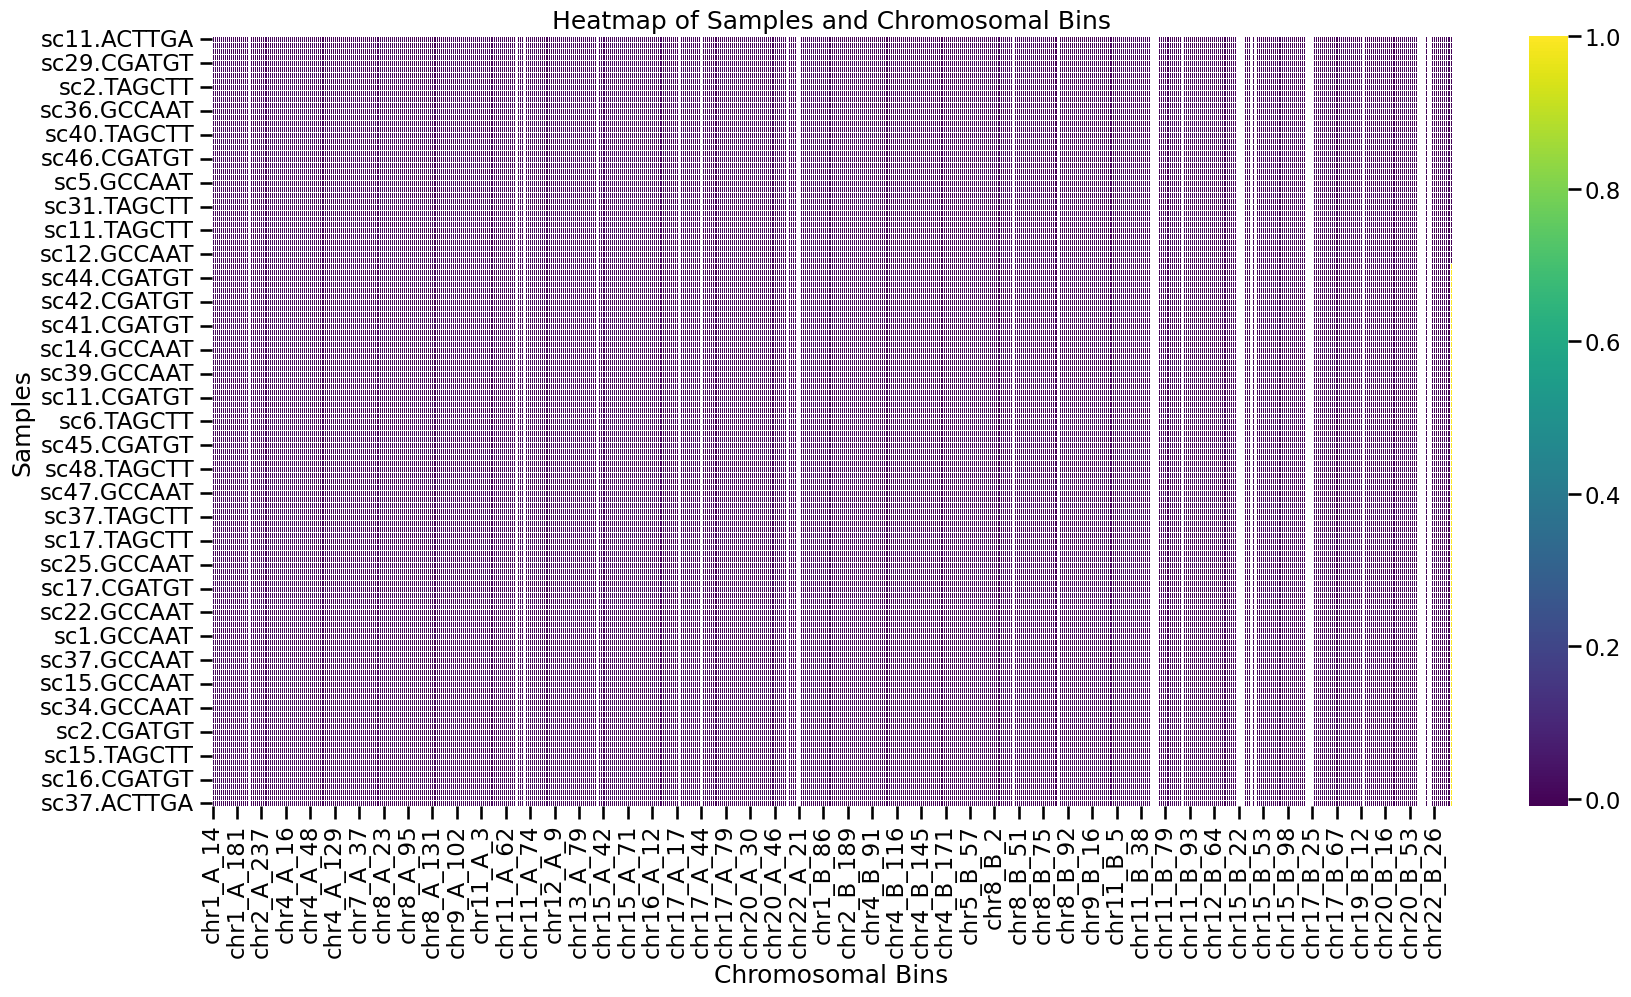

In [120]:
# Set the context for the plot
sns.set_context('talk')

# Create the heatmap
plt.figure(figsize=(20, 10))  # Adjust the figure size as necessary
sns.heatmap(sorted_combined_df, cmap='viridis', linewidths=.5)  # You can change the colormap to your preference

# Adding labels and title, if needed
plt.title('Heatmap of Samples and Chromosomal Bins')
plt.xlabel('Chromosomal Bins')
plt.ylabel('Samples')

# Show the plot
plt.show()

In [121]:
# Initialize dictionaries to hold filtered bulk eigenvector data
bulk_eigenvector_gm12878 = {}
bulk_eigenvector_imr90 = {}

for chrom in range(1, 23):
    chromosome = f'chr{chrom}'
    # Keys for GM12878 and IMR90 eigenvector data in the data dictionary
    key_gm12878 = f'res{resolution}_ch{chrom}_KR_eigenvector_GM12878'
    key_imr90 = f'res{resolution}_ch{chrom}_KR_eigenvector_IMR90'
    bulk_eigenvector_gm12878[chromosome] = original_data[key_gm12878]['eigenvalue']
    bulk_eigenvector_imr90[chromosome] = original_data[key_imr90]['eigenvalue']



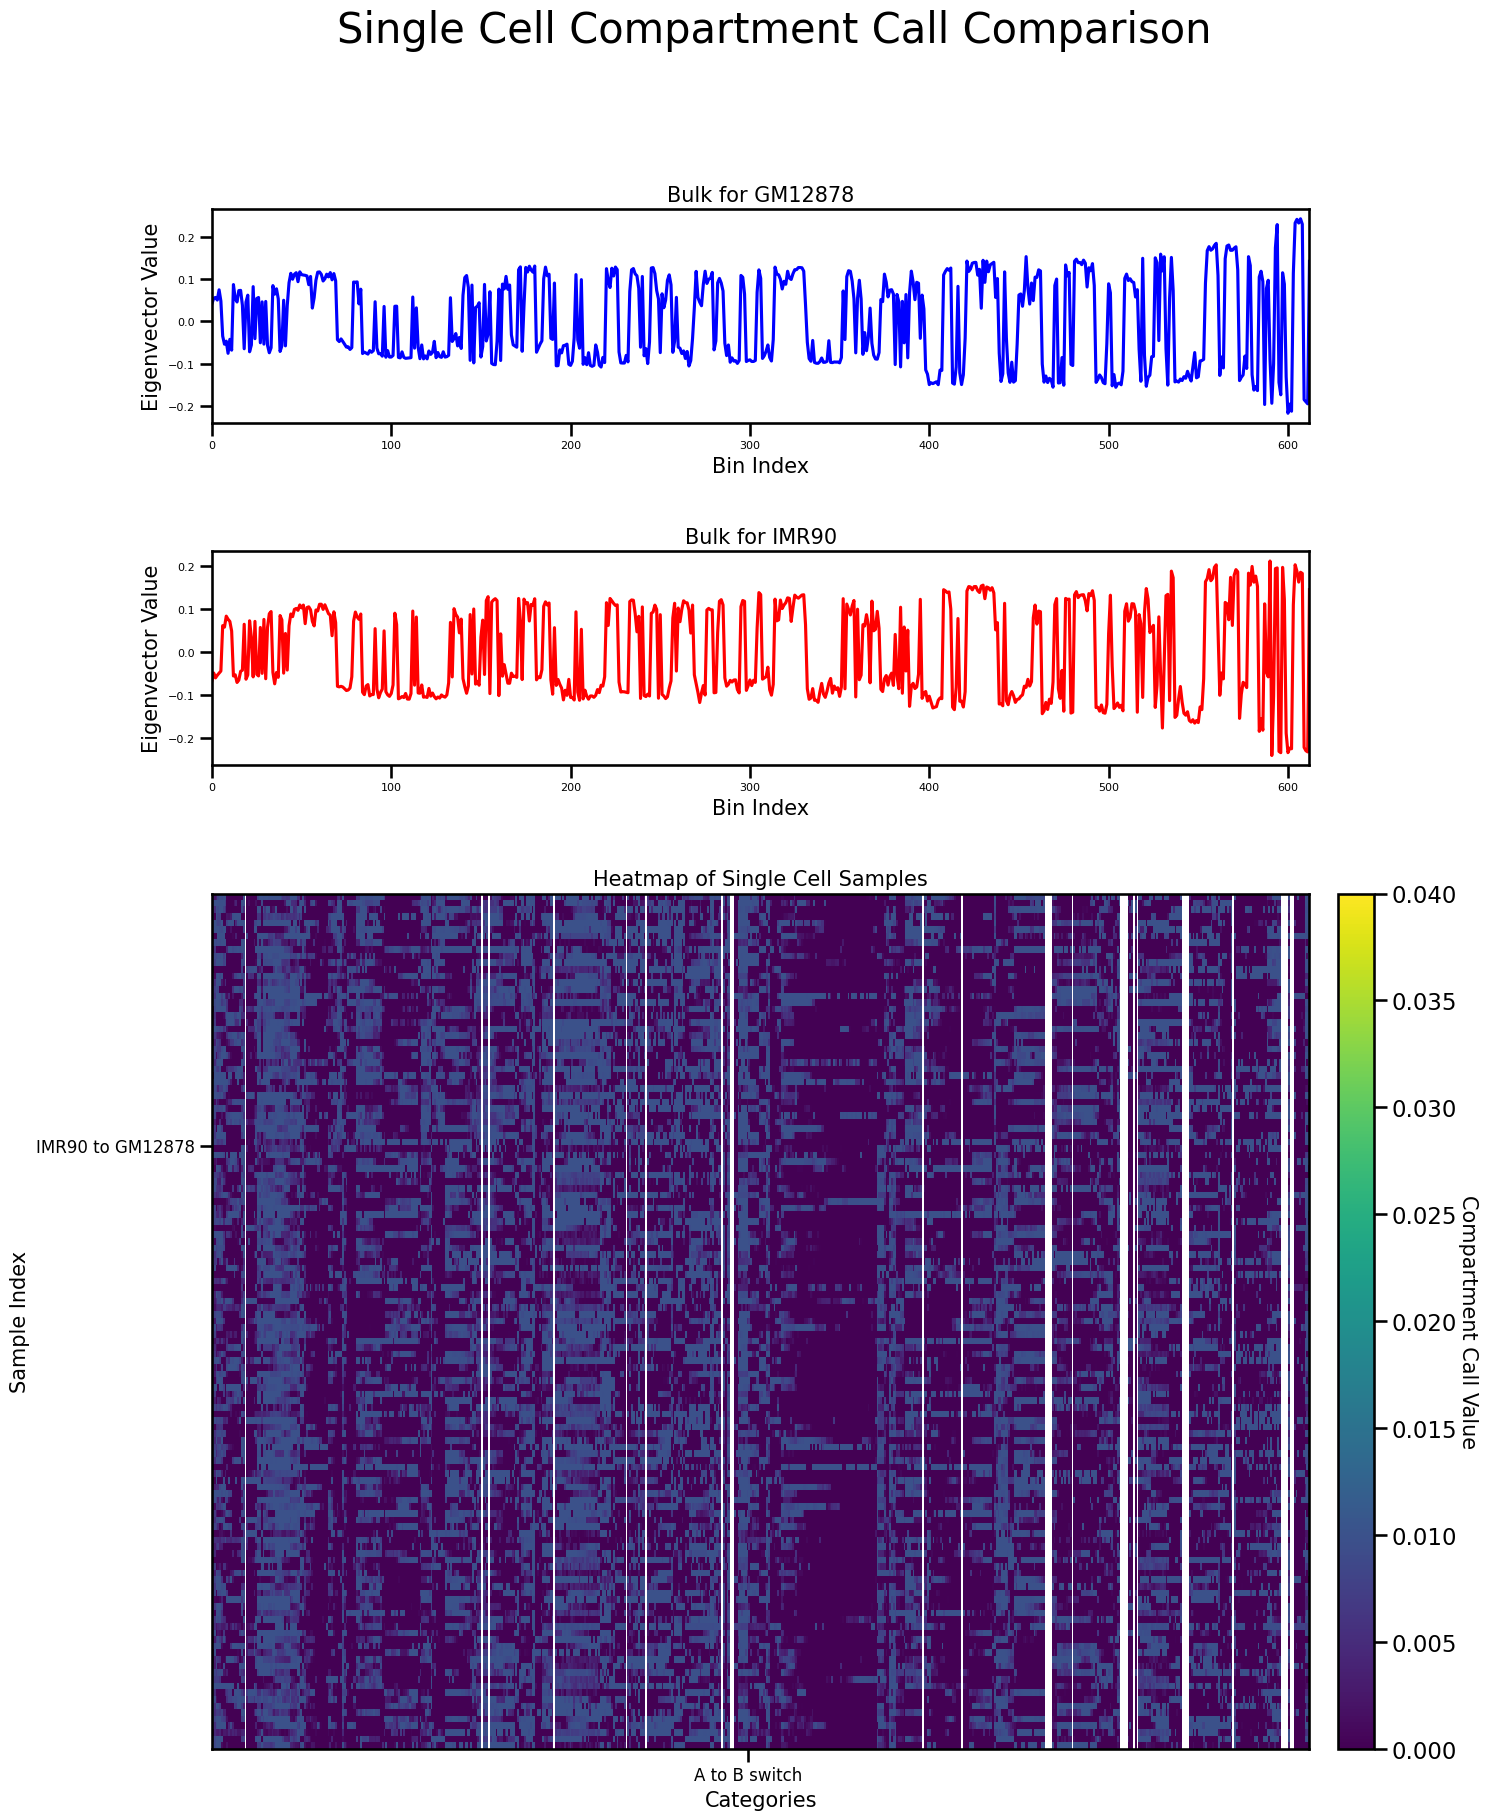

In [122]:
def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    # Set up the figure and GridSpec layout
    fig = plt.figure(figsize=(15, 20))  # Adjust figure size as needed
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig,
                           width_ratios=[30, 1],
                           height_ratios=[1, 1, 4],
                           hspace=0.3, wspace=0.05)

    # Plotting the first bulk eigenvector
    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='blue')
    ax_bulk1.set_title(title1, fontsize=15)
    ax_bulk1.tick_params(labelsize=8)
    ax_bulk1.set_xlim(0, len(bulk_eigenvector1) - 1)
    ax_bulk1.set_xlabel("Bin Index", fontsize=15)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=15)

    # Plotting the second bulk eigenvector
    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='red')
    ax_bulk2.set_title(title2, fontsize=15)
    ax_bulk2.tick_params(labelsize=8)
    ax_bulk2.set_xlim(0, len(bulk_eigenvector2) - 1)
    ax_bulk2.set_xlabel("Bin Index", fontsize=15)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=15)

     # Creating the heatmap
    ax_sc = fig.add_subplot(gs[2, 0])
    sc_data_array = sc_dataframe.drop('Cell_Type', axis=1).to_numpy()
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=0.04)
    
    # Define the transition point between A and B bins on x-axis
    columns = sc_dataframe.columns.drop('Cell_Type')
    a_bin_end = max([i for i, col in enumerate(columns) if '_A_' in col]) + 0.5  # Add 0.5 for the middle of the transition
    
    # Define the transition point between two cell types on y-axis
    cell_type_transition = (sc_dataframe['Cell_Type'] == 0).sum() - 0.5  # Subtract 0.5 to place the label in the middle of the transition

    # Set the x-ticks and y-ticks to show transitions
    ax_sc.set_xticks([a_bin_end])
    ax_sc.set_xticklabels(['A to B switch'], fontsize=12)

    ax_sc.set_yticks([cell_type_transition])
    ax_sc.set_yticklabels(['IMR90 to GM12878'], fontsize=12)

    ax_sc.set_title("Heatmap of Single Cell Samples", fontsize=15)
    ax_sc.set_xlabel("Categories", fontsize=15)
    ax_sc.set_ylabel("Sample Index", fontsize=15)

    # Add colorbar in its own subplot
    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('Compartment Call Value', rotation=270, labelpad=15, fontsize=15)

    plt.suptitle(title, fontsize=30)
    plt.show()


def filter_bulk_data(bulk_data, indices_to_keep_A, indices_to_keep_B):
    filtered_bulk_data = []
    for chrom in bulk_data.keys():
        # Check if the chromosome is present in both indices_to_keep_A and indices_to_keep_B
        if chrom in indices_to_keep_A and chrom in indices_to_keep_B:
            # Concatenate indices from A and B
            combined_indices = np.concatenate([indices_to_keep_A[chrom], indices_to_keep_B[chrom]])
            # Sort the combined indices to maintain original order
            combined_indices_sorted = np.sort(combined_indices)
            # Filter the bulk data for this chromosome using the combined and sorted indices
            filtered_bulk = bulk_data[chrom][combined_indices_sorted]
            filtered_bulk_data.extend(filtered_bulk)
    return np.array(filtered_bulk_data)

# Filter the bulk eigenvector data for GM12878 and IMR90
bulk_eigenvector_gm12878_filtered = filter_bulk_data(bulk_eigenvector_gm12878, indices_to_keep_A, indices_to_keep_B)
bulk_eigenvector_imr90_filtered = filter_bulk_data(bulk_eigenvector_imr90, indices_to_keep_A, indices_to_keep_B)

# Use the filtered bulk eigenvector data for plotting
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878_filtered,
    bulk_eigenvector_imr90_filtered,    
    sorted_combined_df,  
    "Bulk for GM12878",
    "Bulk for IMR90",
    "Single Cell Compartment Call Comparison"
)

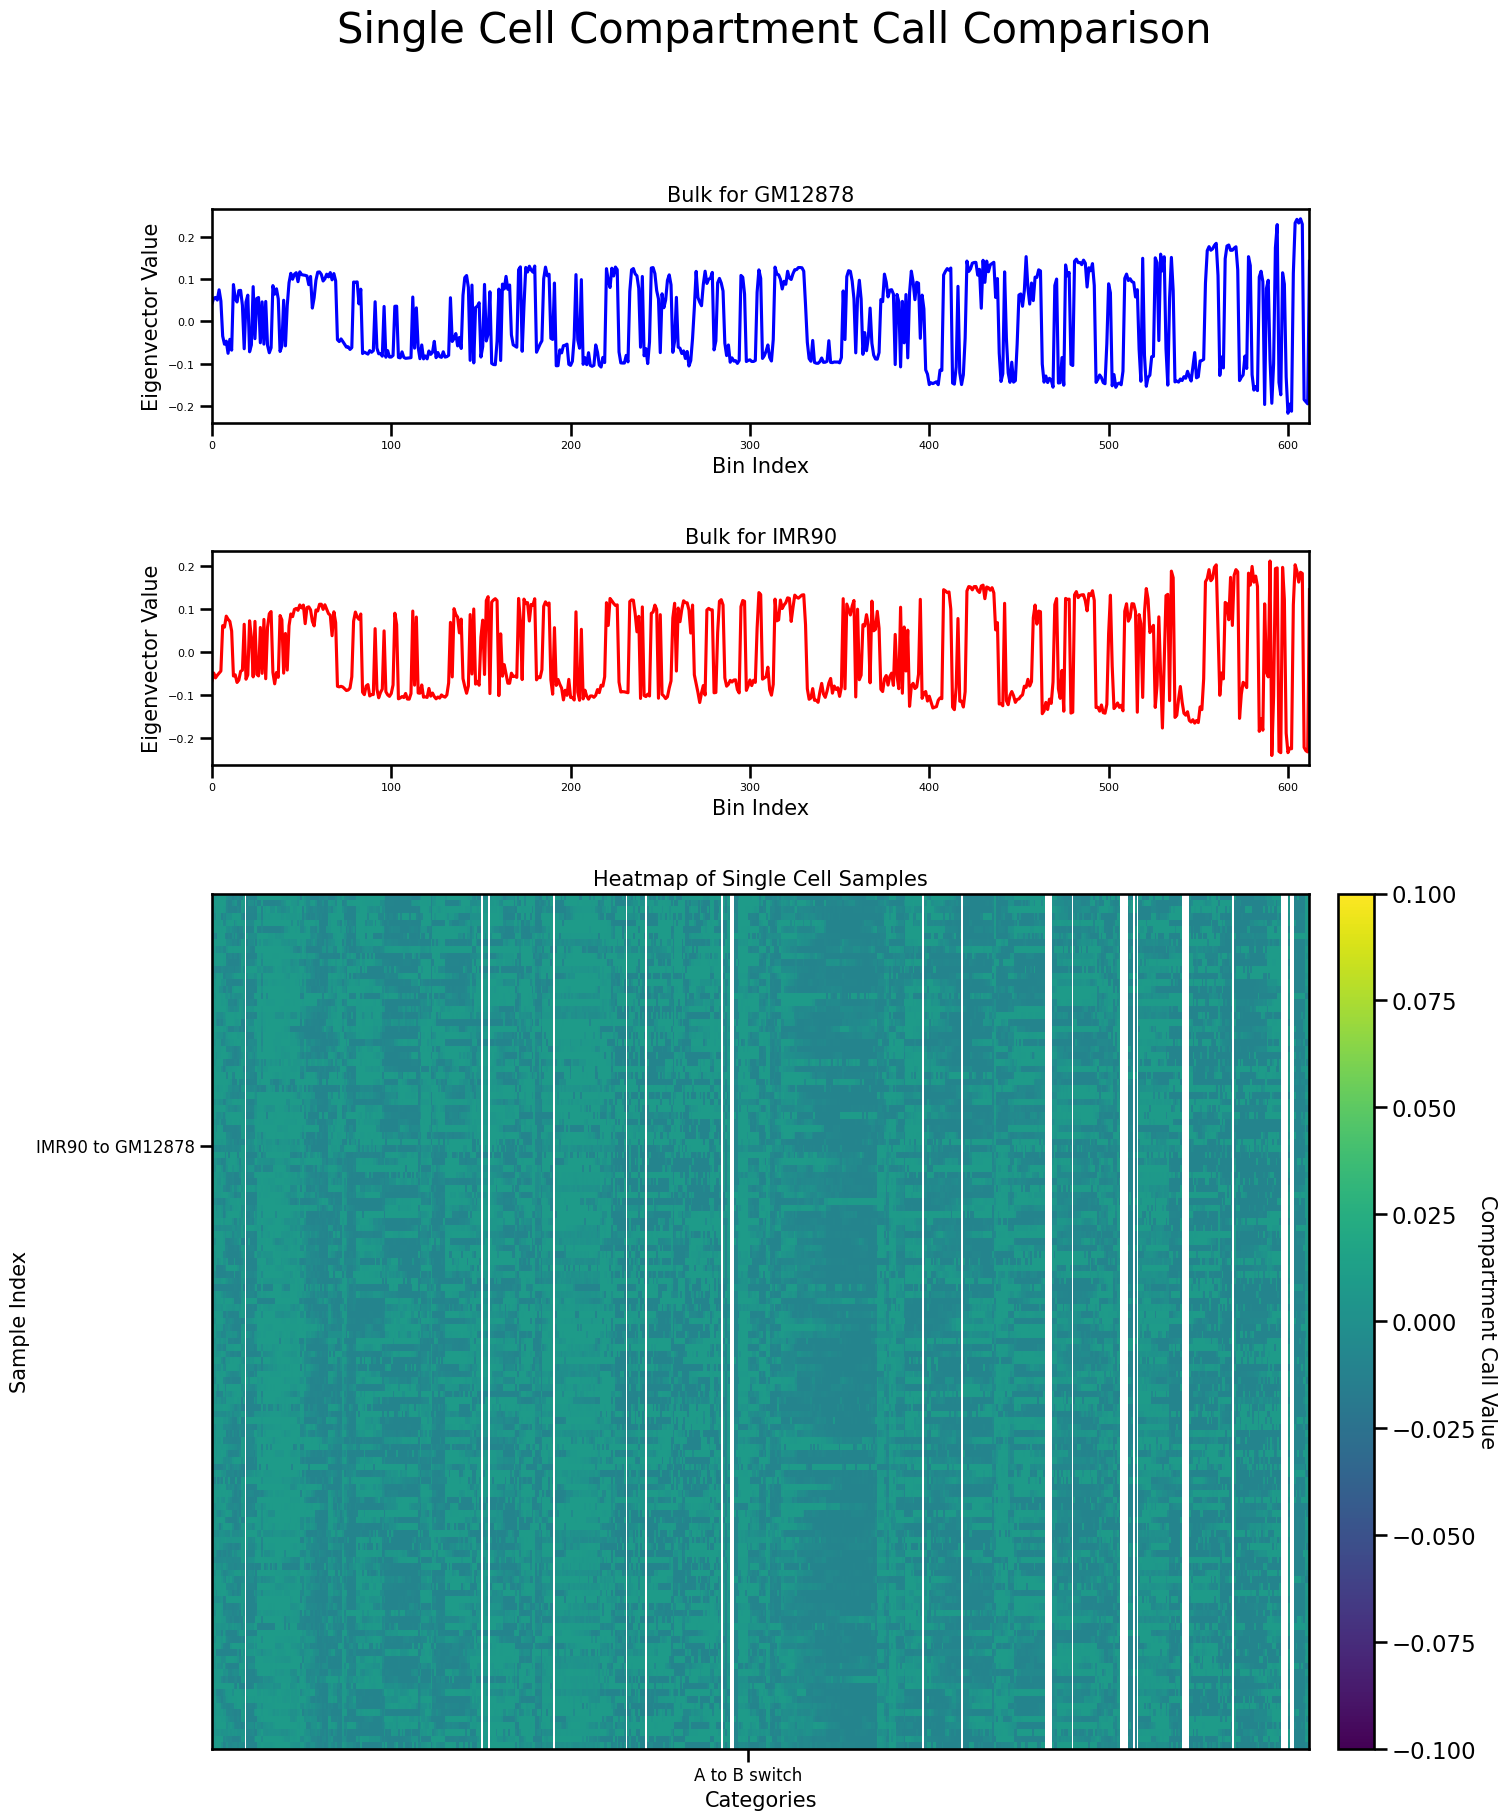

In [123]:
def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    # Set up the figure and GridSpec layout
    fig = plt.figure(figsize=(15, 20))  # Adjust figure size as needed
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig,
                           width_ratios=[30, 1],
                           height_ratios=[1, 1, 4],
                           hspace=0.3, wspace=0.05)

    # Plotting the first bulk eigenvector
    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='blue')
    ax_bulk1.set_title(title1, fontsize=15)
    ax_bulk1.tick_params(labelsize=8)
    ax_bulk1.set_xlim(0, len(bulk_eigenvector1) - 1)
    ax_bulk1.set_xlabel("Bin Index", fontsize=15)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=15)

    # Plotting the second bulk eigenvector
    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='red')
    ax_bulk2.set_title(title2, fontsize=15)
    ax_bulk2.tick_params(labelsize=8)
    ax_bulk2.set_xlim(0, len(bulk_eigenvector2) - 1)
    ax_bulk2.set_xlabel("Bin Index", fontsize=15)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=15)

     # Creating the heatmap
    ax_sc = fig.add_subplot(gs[2, 0])
    sc_data_array = sc_dataframe.drop('Cell_Type', axis=1).to_numpy()

    # Determine the min and max values of your data for color scaling
    vmin = sc_data_array.min()
    vmax = sc_data_array.max()

    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
    
    # Define the transition point between A and B bins on x-axis
    columns = sc_dataframe.columns.drop('Cell_Type')
    a_bin_end = max([i for i, col in enumerate(columns) if '_A_' in col]) + 0.5  # Add 0.5 for the middle of the transition
    
    # Define the transition point between two cell types on y-axis
    cell_type_transition = (sc_dataframe['Cell_Type'] == 0).sum() - 0.5  # Subtract 0.5 to place the label in the middle of the transition

    # Set the x-ticks and y-ticks to show transitions
    ax_sc.set_xticks([a_bin_end])
    ax_sc.set_xticklabels(['A to B switch'], fontsize=12)

    ax_sc.set_yticks([cell_type_transition])
    ax_sc.set_yticklabels(['IMR90 to GM12878'], fontsize=12)

    ax_sc.set_title("Heatmap of Single Cell Samples", fontsize=15)
    ax_sc.set_xlabel("Categories", fontsize=15)
    ax_sc.set_ylabel("Sample Index", fontsize=15)

    # Add colorbar in its own subplot
    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('Compartment Call Value', rotation=270, labelpad=15, fontsize=15)

    plt.suptitle(title, fontsize=30)
    plt.show()

def filter_bulk_data(bulk_data, indices_to_keep_A, indices_to_keep_B):
    filtered_bulk_data = []
    for chrom in bulk_data.keys():
        # Check if the chromosome is present in both indices_to_keep_A and indices_to_keep_B
        if chrom in indices_to_keep_A and chrom in indices_to_keep_B:
            # Concatenate indices from A and B
            combined_indices = np.concatenate([indices_to_keep_A[chrom], indices_to_keep_B[chrom]])
            # Sort the combined indices to maintain original order
            combined_indices_sorted = np.sort(combined_indices)
            # Filter the bulk data for this chromosome using the combined and sorted indices
            filtered_bulk = bulk_data[chrom][combined_indices_sorted]
            filtered_bulk_data.extend(filtered_bulk)
    return np.array(filtered_bulk_data)

# Filter the bulk eigenvector data for GM12878 and IMR90
bulk_eigenvector_gm12878_filtered = filter_bulk_data(bulk_eigenvector_gm12878, indices_to_keep_A, indices_to_keep_B)
bulk_eigenvector_imr90_filtered = filter_bulk_data(bulk_eigenvector_imr90, indices_to_keep_A, indices_to_keep_B)

# Use the filtered bulk eigenvector data for plotting
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878_filtered,
    bulk_eigenvector_imr90_filtered,    
    sorted_combined_df,  
    "Bulk for GM12878",
    "Bulk for IMR90",
    "Single Cell Compartment Call Comparison"
)

In [124]:
sorted_combined_df

,chr1_A_14,chr1_A_18,chr1_A_30,chr1_A_34,chr1_A_37,chr1_A_47,chr1_A_111,chr1_A_117,chr1_A_152,chr1_A_157,...,chr22_B_25,chr22_B_26,chr22_B_32,chr22_B_33,chr22_B_34,chr22_B_35,chr22_B_47,chr22_B_48,chr22_B_49,Cell_Type
sc11.ACTTGA,0.004021,0.002571,0.004124,0.008360,0.009681,0.009341,0.009996,0.009754,0.000417,-0.003477,...,-0.009990,-0.009964,0.009741,-0.010000,-0.010000,-0.009999,0.010000,0.009351,0.010000,0
sc24.CGATGT,0.008829,0.009881,0.009879,0.010000,0.009764,0.009701,0.010000,0.008048,-0.006366,-0.009899,...,-0.010000,-0.009996,-0.009858,-0.010000,-0.009999,-0.010000,0.010000,0.010000,0.010000,0
sc25.TAGCTT,0.005474,0.005015,0.009557,0.009035,0.009871,0.010000,0.008373,0.005307,-0.006942,-0.009949,...,-0.009485,-0.009951,-0.009953,-0.009957,-0.009717,-0.009988,0.009676,0.009613,0.009510,0
sc27.TAGCTT,0.006048,-0.000852,0.009726,0.007962,0.007814,-0.009998,-0.002617,-0.007334,0.002230,0.001982,...,-0.010000,-0.010000,-0.009953,-0.007674,-0.007337,-0.007391,0.009998,0.010000,0.009993,0
sc29.CGATGT,0.010000,0.010000,0.009021,0.007889,0.008321,0.010000,-0.005581,-0.003730,0.008093,0.009974,...,0.005358,-0.009843,-0.009797,-0.010000,-0.010000,-0.009596,0.010000,0.010000,0.010000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sc16.CGATGT,0.008428,0.008221,0.009816,0.010000,0.010000,0.008219,0.007477,0.006054,0.001798,-0.001958,...,-0.010000,-0.009971,-0.010000,-0.010000,-0.010000,-0.009983,0.010000,-0.004902,-0.003314,1
sc30.ACTTGA,0.005402,0.005223,0.009207,0.010000,0.010000,0.010000,0.009985,0.009979,-0.000712,0.004328,...,-0.003848,-0.010000,-0.010000,-0.010000,-0.004370,-0.009831,0.010000,0.010000,0.010000,1
sc16.GCCAAT,0.000604,0.004575,0.002978,0.002906,0.004055,0.001181,0.002845,0.002868,0.002308,0.004620,...,-0.010000,-0.010000,-0.009997,-0.009999,-0.009995,-0.009997,0.004437,0.005930,0.005870,1
sc32.GCCAAT,0.005618,0.008530,0.009996,0.010000,0.010000,0.010000,-0.006112,0.000298,-0.004623,-0.006941,...,-0.009479,-0.010000,-0.010000,-0.010000,-0.009472,-0.010000,0.009193,0.010000,0.002321,1


In [125]:
# Extract all the data except for the 'Cell_Type' column
data_matrix = sorted_combined_df.drop(columns=['Cell_Type']).values
data_matrix.shape

(129, 608)

In [126]:
# Remove columns with any NaN values
data_matrix_cleaned = sorted_combined_df.drop(columns=['Cell_Type']).dropna(axis=1).values
data_matrix_cleaned.shape

(129, 575)

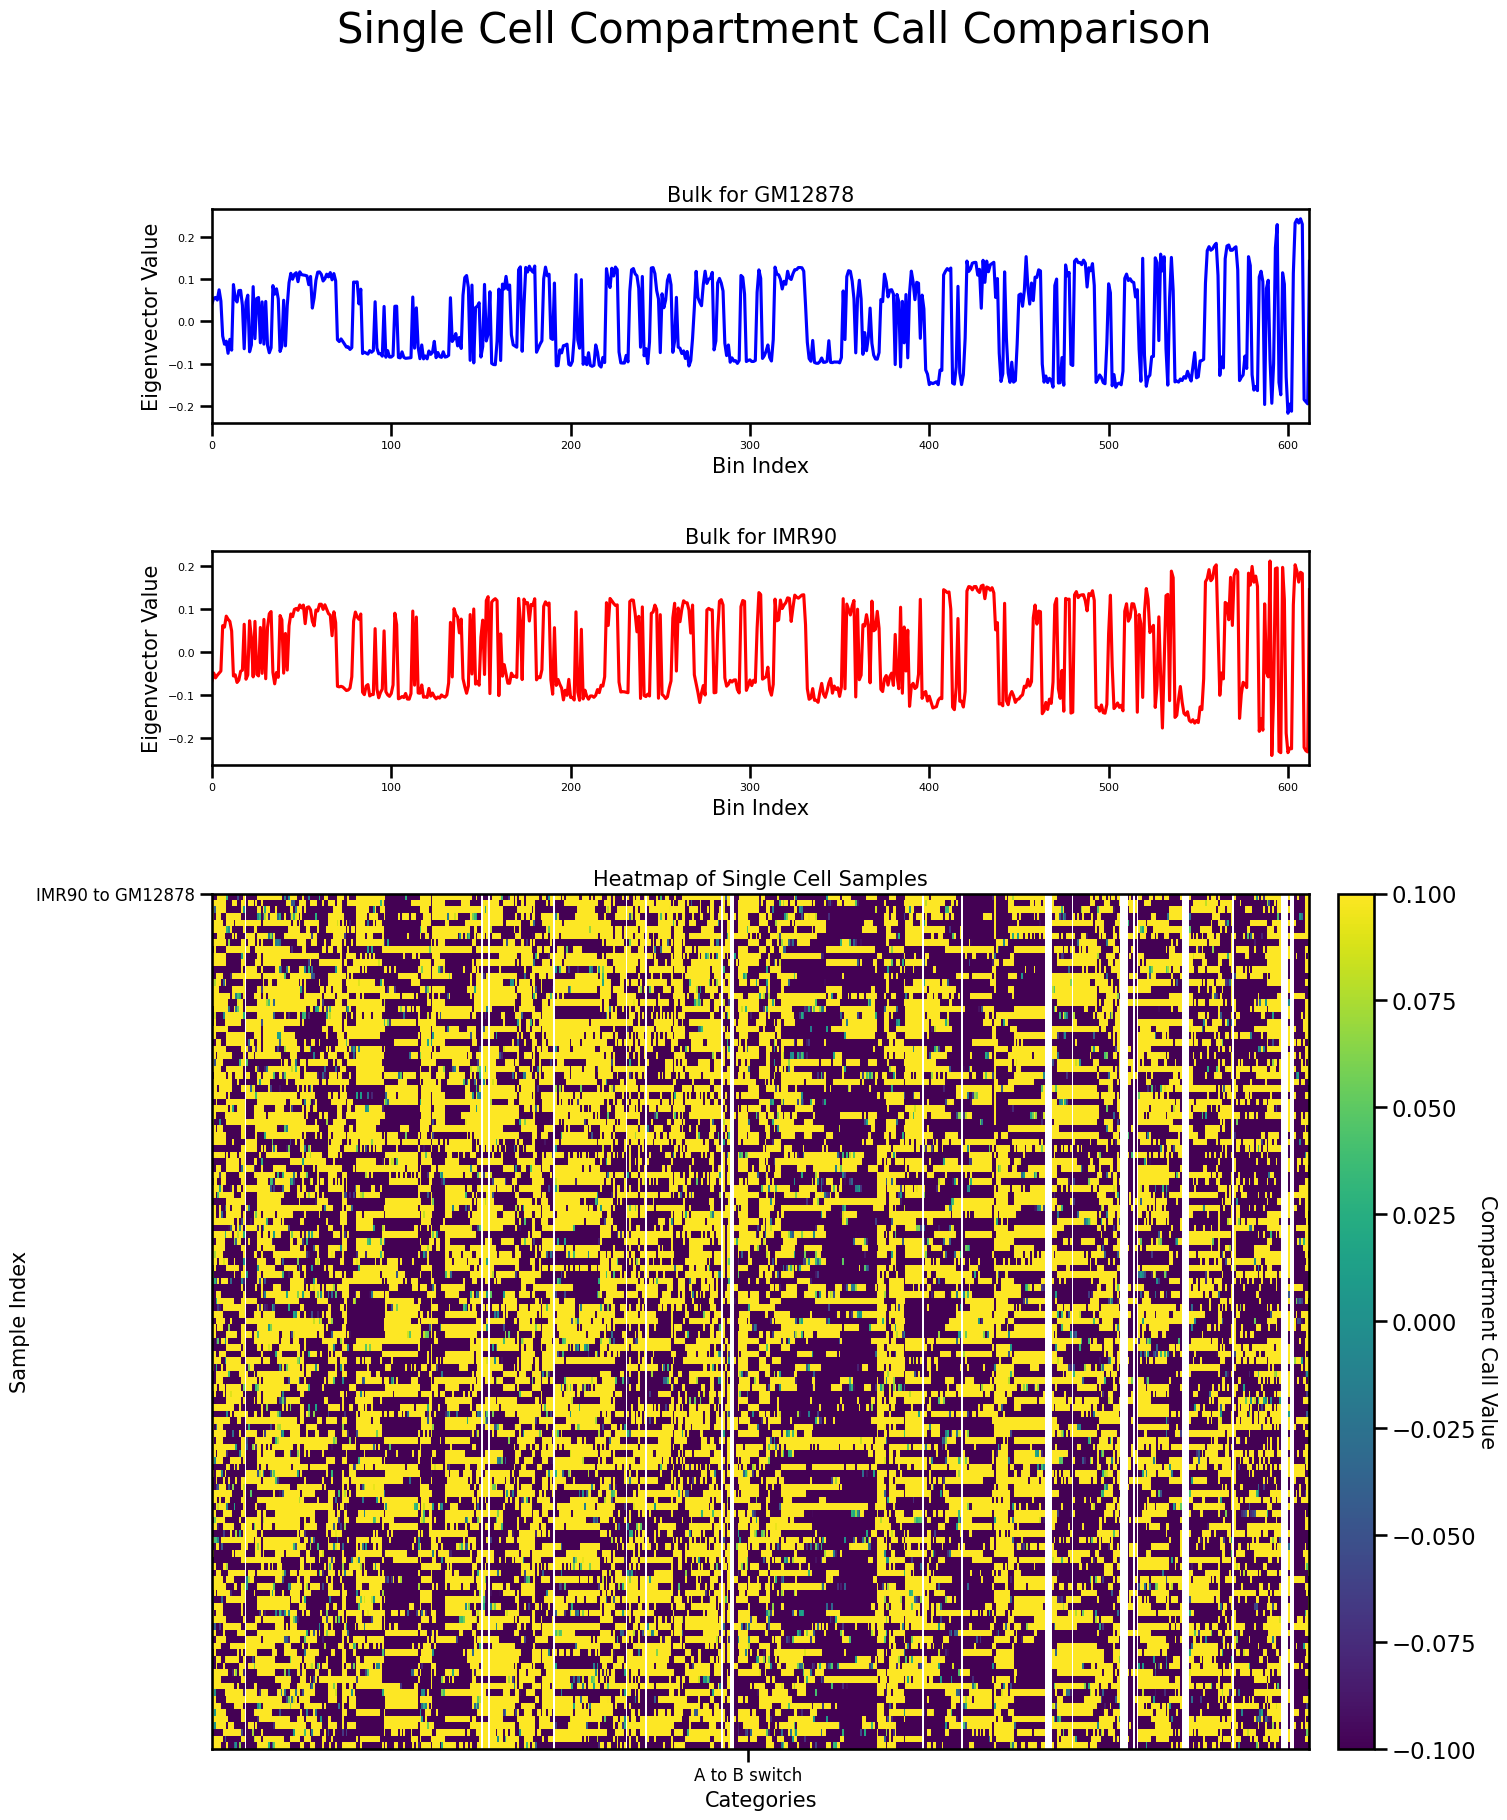

In [127]:
final_df_zscore = sorted_combined_df.apply(zscore, axis=0)

# Filter the bulk eigenvector data for GM12878 and IMR90
bulk_eigenvector_gm12878_filtered = filter_bulk_data(bulk_eigenvector_gm12878, indices_to_keep_A, indices_to_keep_B)
bulk_eigenvector_imr90_filtered = filter_bulk_data(bulk_eigenvector_imr90, indices_to_keep_A, indices_to_keep_B)

# Use the filtered bulk eigenvector data for plotting
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878_filtered,
    bulk_eigenvector_imr90_filtered,    
    final_df_zscore, 
    "Bulk for GM12878",
    "Bulk for IMR90",
    "Single Cell Compartment Call Comparison"
)

In [89]:
# Assuming tensor_factors[1] is your 153x4 matrix
Y = data_matrix_cleaned

# Assuming Y is your methylation matrix and is defined
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE to reduce dimensions from the original space to 2D
Y_2d_hic = tsne.fit_transform(Y)


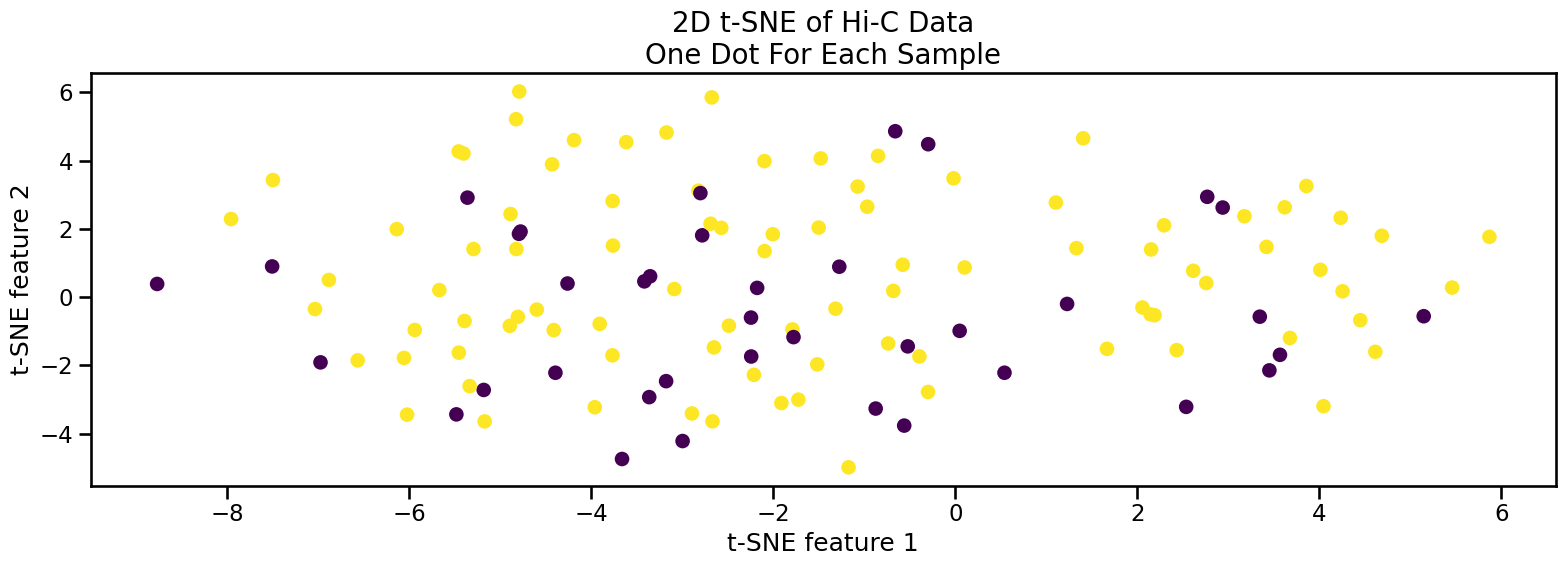

In [90]:
fig, ax = plt.subplots(figsize=(16, 6))

# Scatter plot for Z_2d (t-SNE on the transposed matrix)
ax.scatter(Y_2d_hic[:, 0], Y_2d_hic[:, 1], c=color_vector)
ax.set_title('2D t-SNE of Hi-C Data\nOne Dot For Each Sample', fontsize=20)
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the figure
plt.show()